In [18]:
import numpy as np
import batman
import matplotlib.pyplot as plt
import warnings
# from transit_search import amplitude_spectrum

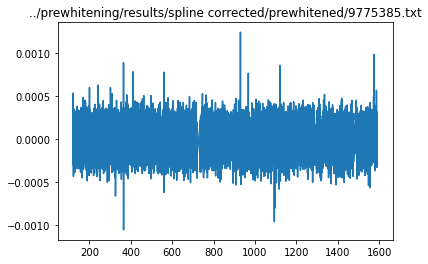

In [4]:
import glob
import numpy as np
# file = glob.glob('/Volumes/silo2/dhey3294/AF Transit/data/lc_pdc/*7697795*')[0]
file = glob.glob('../data/lightcurves/spline corrected PDC/lc/*')[3]#[100]
file = glob.glob('../prewhitening/results/spline corrected/prewhitened/*')[20]

time, flux, flux_err = np.loadtxt(file).T
flux /= 1e3
time = np.ascontiguousarray(time)
plt.plot(time, flux)
plt.title(file)
plt.show()
# plt.plot(*amplitude_spectrum(time, flux))
# plt.xlim(0,1)

In [5]:
import astropy.units as u
(1 * u.R_jup).to(u.R_sun)

<Quantity 0.10276269 solRad>

In [6]:
def generate_transit_model(time, period, rp):
    stellar_rad=1.7
    params = batman.TransitParams()
    params.t0 = time[0]                 #time of inferior conjunction
    params.per = period                      #orbital period
    params.rp = rp                   #planet radius (in units of stellar radii)
    params.a = 30.                       #semi-major axis (in units of stellar radii)
    params.inc = 90#np.degrees(np.arccos(0.5 * 1.7 / params.a))                     #orbital inclination (in degrees)
    params.ecc = 0.                    #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"   

    m = batman.TransitModel(params, time)    #initializes model
    batman_flux = m.light_curve(params) - 1
    return batman_flux

### Let's fit the transit as both a transit and pulsation and see which one has the lower BIC...

In [75]:
from astropy.timeseries import LombScargle, BoxLeastSquares
from scipy.optimize import curve_fit

def amplitude_spectrum(t, y, fmin=None, fmax=None, oversample_factor=10.0):
    
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = 0.5 / np.median(np.diff(t))  # *nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4.0 / len(t))
    amp = np.sqrt(sc) * fct

    return freq, amp

def grad_model(time, freq, amp, phi):
    factor = 2 * np.pi * freq * time + phi
    return np.array([
        -2*np.pi*amp*time*np.sin(factor),
        np.cos(factor),
        -1 * amp * np.sin(factor)
    ]).T

def dft_phase(x, y, f):
    expo = 2.0 * np.pi * f * x
    ft_real = np.sum(y * np.cos(expo))
    ft_imag = np.sum(y * np.sin(expo))
    return np.arctan2(ft_imag, ft_real)

def model(time, freq, amp, phi):
    return amp * np.cos((2 * np.pi * freq * time) + phi)# + 1

def prewhiten(time, flux, theta, transit_check_cutoff=1.):
    popt, _ = curve_fit(model, time, flux, p0=theta, jac=grad_model)
    
    if theta[0] < transit_check_cutoff:
        # Now we fit a BLS 
        bls = BoxLeastSquares(time, flux)
        bls_power = bls.power([1/theta[0]], 0.2)
        bls_transit = bls.model(time, bls_power.period[0], bls_power.duration[0], bls_power.transit_time[0])
        
        # Now calculate the BIC of both models:
        nll_osc = -0.5 * np.sum((flux - model(time, *popt)) ** 2)
        nll_trans = -0.5 * np.sum((flux - bls_transit) ** 2)
        BIC = [-2 * (nll_osc) + np.log(len(time)) * 2, -2 * (nll_trans) + np.log(len(time)) * 2]
        print(BIC)
        if np.argmin(BIC) > 0:
            print("This is a transit at {}!".format(theta[0]))
            
    return flux - model(time, *popt), popt, theta

def initialize_theta(time, flux, fmin, fmax):
    f, a = amplitude_spectrum(time, flux, fmin=fmin, fmax=fmax, oversample_factor=5.)
    noise = estimate_background(f,a, log_width=0.05)
    snr = a/noise
    # Get freq of max SNR
    f0 = find_highest_peak(f, snr)
    # Calculate a0 at f0
    a0 = np.sqrt(LombScargle(time, flux).power(f0, method="fast", normalization="psd")) * np.sqrt(4.0 / len(time))
    # Calculate phi0, since ASTC need to negative it
    phi0 = -1 * dft_phase(time, flux, f0)
    
#     plt.plot(f, snr)
#     plt.show()
    return [f0, a0, phi0], snr[np.nanargmax(snr)], f, a

def find_highest_peak(f, a):
    """
    Find the frequency of the highest peak in the periodogram, using a
    3-point parabolic interpolation.
    """
    nu, p = f, a
    nu, p = np.atleast_1d(nu, p)

    # Get index of highest peak.
    imax = np.argmax(p)

    # Determine the frequency value by parabolic interpolation
    if imax == 0 or imax == p.size - 1:
        nu_peak = p[imax]
    else:
        # Get values around the maximum.
        frq1 = nu[imax-1]
        frq2 = nu[imax]
        frq3 = nu[imax+1]
        y1 = p[imax-1]
        y2 = p[imax]
        y3 = p[imax+1]

        # Parabolic interpolation formula.
        t1 = (y2-y3) * (frq2-frq1)**2 - (y2-y1) * (frq2-frq3)**2
        t2 = (y2-y3) * (frq2-frq1) - (y2-y1) * (frq2-frq3)
        nu_peak = frq2 - 0.5 * t1/t2
    if nu_peak > 1:
        return 1.
    return nu_peak

def estimate_background(x, y, log_width=0.01):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

In [51]:
import tqdm
files = glob.glob('../prewhitening/results/spline corrected/prewhitened/*')

## Let's prewhiten the whole set now ...

In [91]:
def low_freq_prewhiten(file, fmin=1e-3, fmax=1., snr_cutoff=4, maxiter=20):
    
    x, y, yerr = np.loadtxt(file).T
    x = np.ascontiguousarray(x)
    y /= 1e3
    yerr /= 1e3
    
    j = 0
    theta, snr, f,a = initialize_theta(x, y, fmin, fmax)
    while((snr > snr_cutoff) & (j < maxiter)):
        
        popt, _ = curve_fit(model, x, y, p0=theta, jac=grad_model)
        
        # Now we fit a BLS t
        bls = BoxLeastSquares(x, y)
        bls_power = bls.power([1/theta[0]], 0.2)
        bls_transit = bls.model(x, bls_power.period[0], bls_power.duration[0], bls_power.transit_time[0])

        # Now calculate the BIC of both models:
        BIC = [-2 * (-0.5 * np.sum((y - model(x, *popt)) ** 2)) + np.log(len(x)) * 2, 
               -2 * (-0.5 * np.sum((y - bls_transit) ** 2)) + np.log(len(x)) * 2]

        if np.argmin(BIC) == 0:
            # We think it's an oscillation -- prewhiten and continue
            y -= model(x, *popt)
            j += 1
            theta, snr, f,a = initialize_theta(x, y, fmin, fmax)
            continue
        else:
            # We think it's a transit - break the prewhitening and exit
#             warnings.warn("Transit?")
            return x, y, yerr
    # Either finished prewhitening or code think it found a transit..
    return x, y, yerr
        

In [92]:
import tqdm

for file in tqdm.tqdm(files[:]):
    x, y, yerr = low_freq_prewhiten(file)
    kicid = file.split('/')[-1].split('.')[0]
    np.savetxt(f'../prewhitening/results/BIC/{kicid}.txt', list(zip(x, y*1e3, yerr*1e3)))

  1%|          | 24/2158 [01:02<2:00:00,  3.37s/it]/home/daniel/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniel/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2158/2158 [1:37:32<00:00,  2.71s/it]  


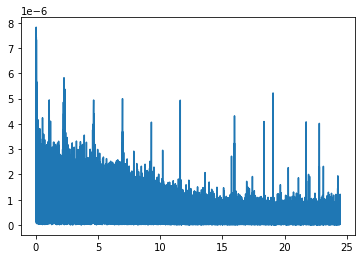

In [87]:
x, y, yerr = low_freq_prewhiten(files[150])
plt.plot(*amplitude_spectrum(x,y))

In [236]:
np.random.seed(23)
snr_cutoff=4
maxiter=20
fmin, fmax = 1e-3, 0.99
n_stars = 1000
tp, tn, fp, fn = 0, 0, 0, 0

ytrue, ypred = [], []

for i, file in tqdm.tqdm(enumerate(np.random.choice(files, size=(n_stars))), total=n_stars):
    x, y, yerr = np.loadtxt(file).T
    x = np.ascontiguousarray(x)
    y /= 1e3
    
    # Add in a transit...
    porb = np.random.uniform(low=2, high=50)
    aliases = [(1/porb) * i for i in range(int(np.ceil(porb)))]
#     transit_injected = False
#     if i % 2 == 0:
    transit_injected = True
    rp = np.random.uniform(low=0.01, high=0.1)
    transit_model = generate_transit_model(x, porb, rp)
    y += transit_model
    
    theta, snr, f,a = initialize_theta(x, y, fmin, fmax)
    j = 0
    while((snr > snr_cutoff) & (j < maxiter)):
        
#         plt.plot(f,a)
#         plt.axvline(theta[0], c='r', linestyle='dashed')
#         plt.show()
        
        popt, _ = curve_fit(model, x, y, p0=theta, jac=grad_model)
        if theta[0] < 1:
            # Now we fit a BLS 
            bls = BoxLeastSquares(x, y)
            bls_power = bls.power([1/theta[0]], 0.2)
            bls_transit = bls.model(x, bls_power.period[0], bls_power.duration[0], bls_power.transit_time[0])

            # Now calculate the BIC of both models:
            BIC = [-2 * (-0.5 * np.sum((y - model(x, *popt)) ** 2)) + np.log(len(x)) * 2, 
                   -2 * (-0.5 * np.sum((y - bls_transit) ** 2)) + np.log(len(x)) * 2]
            
            if np.argmin(BIC) == 1: # We think it's a transit
                # and it's actually an injected transit
                if np.any(np.isclose(theta[0], aliases, rtol=1e-3)) & (transit_injected):
#                     print("tp")
                    tp += 1
    
                    ytrue.append(1)
                    ypred.append(1)
                    break
                # and it's not
                else:
                    fp += 1
                    ytrue.append(0)
                    ypred.append(1)
                    break
#                 break
            elif np.argmin(BIC) == 0:
                # we think it's an oscillation:
                # but it's actually an injected transit..
                if np.any(np.isclose(theta[0], aliases, rtol=1e-3) & transit_injected):
                    fn += 1                    
#                     print("fn")
                    ytrue.append(1)
                    ypred.append(0)
                    break
                # and it is an oscillation
                else:
                    ytrue.append(0)
                    ypred.append(0)
                    tn += 1
            else:
                print("how did we get here .. ?")

        y -= model(x, *popt)
        j += 1
        theta, snr, f,a = initialize_theta(x, y, fmin, fmax)
        
np.savetxt('model selection/results.txt', list(zip(ytrue, ypred)))

100%|██████████| 1000/1000 [25:15<00:00,  1.52s/it]


In [13]:
ytrue, ypred = np.loadtxt('results.txt', unpack=True)

In [14]:
plt.style.use('science')

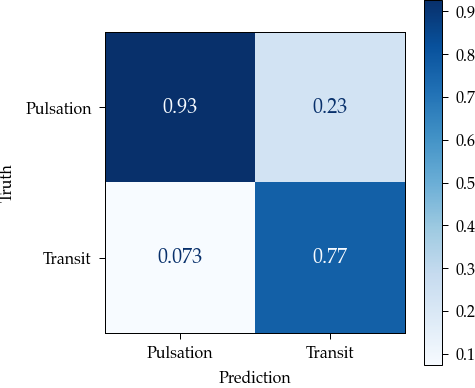

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=mnras_size(242.26653, square=True))

cm = confusion_matrix(ytrue, ypred, 
#                       normalize='all'
                      normalize='pred'
                     )
fig = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=['Pulsation', 'Transit']
                            )

fig.plot(cmap='Blues', ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')

plt.savefig(overleaf_path + 'BIC.pdf')

In [17]:
def mnras_size(fig_width_pt, square=False):
    inches_per_pt = 1.0 / 72.00  # Convert pt to inches
    golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Most aesthetic ratio
    fig_width = fig_width_pt * inches_per_pt  # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width * golden_mean
    return [fig_width, fig_height]

In [25]:
overleaf_path = (
    "/Users/daniel/Dropbox (Sydney Uni)/Apps/Overleaf/AF exoplanet/figures/"
)